In [2]:
import numpy as np
import pandas as pd
from scipy import integrate
from matplotlib import pyplot as plt
from scipy.stats import norm, truncnorm
from scipy.stats import lognorm
from scipy.stats import expon
from scipy.stats import nct
from scipy.stats import chi2
from scipy.stats import hypergeom
from tqdm import tqdm


### Length of conditional/hybrid CI 

In [2]:
def cond_CI_dist(gap, alpha=0.05, eps=1e-8, step=0.5):

    if gap < 0:
        print('gap must be positive')
        return 

    def obj(L):
        return norm.logsf(L) - (np.log(alpha) + norm.logsf(-1*gap + L))
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L
   

def hybrid_CI_dist(gap, n, alpha=0.05, beta=0.005, eps=1e-8, step=0.5):
    
    if gap < 0:
        print('gap must be positive')
        return 

    def B(alpha, n):
        return 1 - (1-alpha)**(1/n)
    
    def obj(L):
        return norm.logsf(L) - np.log( (alpha-beta)/(1-beta) * norm.sf(-1*gap + L) +  (1-alpha)/(1-beta)*B(beta, n) )
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L




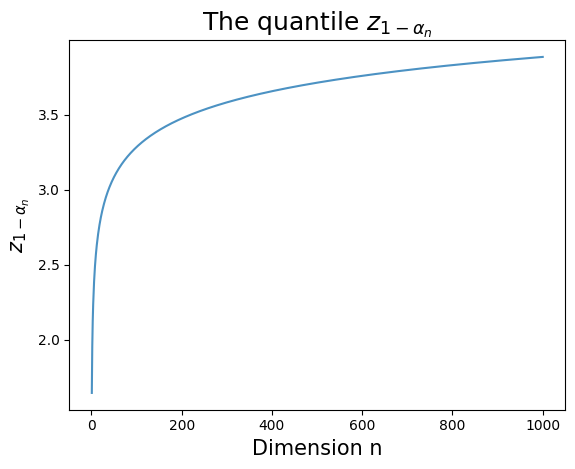

In [7]:
alpha = 0.05
alpha_ = 0.8

x = np.arange(1, 1001)
y = np.array([norm.ppf( (1-alpha) ** (1/i) ) for i in x ]) 

plt.figure()
plt.plot(x, y, alpha=alpha_)

plt.title(r"The quantile $z_{1 - \alpha_n}$", fontsize=18)
plt.xlabel("Dimension n", fontsize=15)
plt.ylabel(r"$z_{1 - \alpha_n}$", fontsize=15)

plt.grid(False)
plt.savefig(f"fig/class_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 373.26it/s]


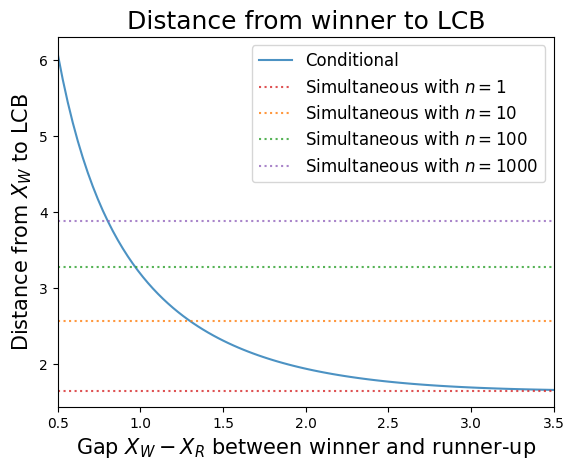

In [6]:
alpha = 0.05
alpha_ = 0.8
x_low = 0.5
x_hi = 3.5
x = np.linspace(x_low, x_hi, 100)
y = np.array([cond_CI_dist(gap) for gap in tqdm(x) ]) 

plt.figure()
plt.plot(x, y, label='Conditional', alpha=alpha_)

# Adding horizontal lines
plt.axhline(y=norm.ppf( (1-alpha) ), color='tab:red', linestyle='dotted', label='Simultaneous with $n=1$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/10) ) , color='tab:orange', linestyle='dotted', label='Simultaneous with $n=10$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/100) ), color='tab:green', linestyle='dotted', label='Simultaneous with $n=100$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/1000) ), color='tab:purple', linestyle='dotted', label='Simultaneous with $n=1000$', alpha=alpha_)

plt.title("Distance from winner to LCB", fontsize=18)
plt.xlabel("Gap $X_{W} - X_{R}$ between winner and runner-up", fontsize=15)
plt.ylabel("Distance from $X_{W}$ to LCB", fontsize=15)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)
plt.savefig(f"fig/cond_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


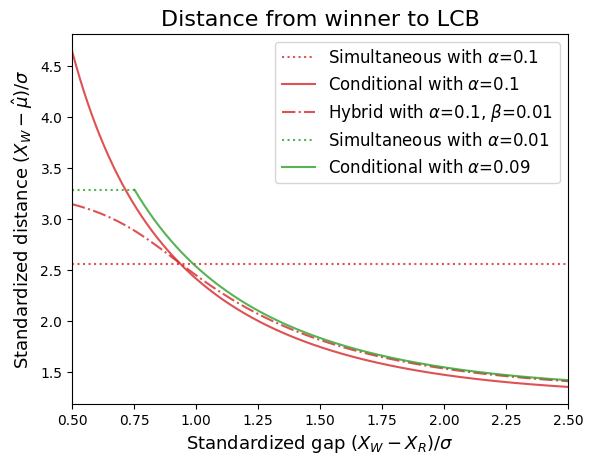

In [18]:
n = 20
alpha = 0.1
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Classical level alpha

plt.axhline(y=norm.ppf( (1-alpha) ** (1/n) ) , color='tab:red', linestyle='dotted', label=f'Simultaneous with $\\alpha$={alpha}', alpha=alpha_)


# Conditional level alpha 
plt.plot(x, np.array([cond_CI_dist(gap, alpha=alpha) for gap in x]), color='tab:red', label=f'Conditional with $\\alpha$={alpha}', alpha=alpha_)

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha, beta=beta) for gap in x]) , color='tab:red', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Simultaneous with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from winner to LCB", fontsize=16)
plt.xlabel("Standardized gap $(X_{W} - X_{R})/\sigma$", fontsize=13)
plt.ylabel("Standardized distance $(X_{W} - \hat{\mu})/\sigma$ ", fontsize=13)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig(f"fig/hyb_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


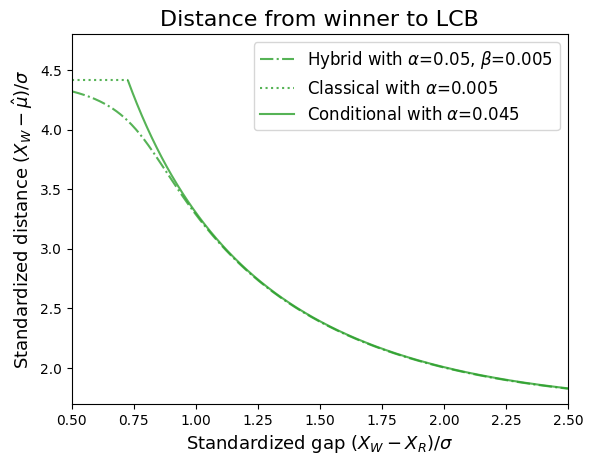

In [21]:
n = 1000
alpha = 0.05
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha) for gap in x]) , color='tab:green', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Classical with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from winner to LCB", fontsize=16)
plt.xlabel("Standardized gap $(X_{W} - X_{R})/\sigma$", fontsize=13)
plt.ylabel("Standardized distance $(X_{W} - \hat{\mu})/\sigma$ ", fontsize=13)
plt.xlim([x_low, x_hi ])
plt.ylim(1.7, 4.8)

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig(f"fig/hyb_dist_to_winner_n={n}.pdf", bbox_inches='tight', pad_inches=0)


<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_33830/1062092769.py:46: SyntaxWarning: invalid escape sequence '\h'
  tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']


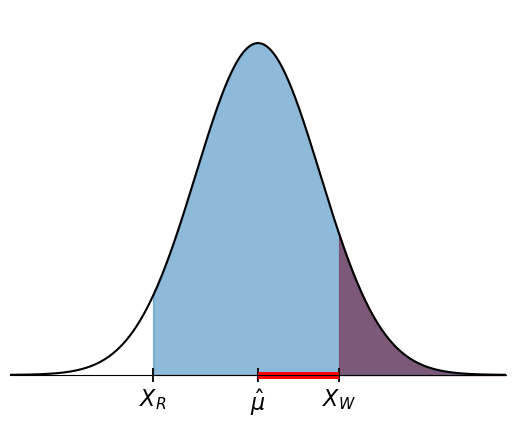

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 0.1
x_w = 0

key_to_x_r = {3 : -0.85, 2: -1.3, 1: -3}

key =  1
x_r = key_to_x_r[key]
mu = x_w - cond_CI_dist(x_w-x_r, alpha=alpha)
sigma = 1

fig, ax = plt.subplots(figsize=([6.4, 4.8]))

# Adjust the bottom spine (x-axis) to start at y=shift
shift = 0.005
plt.gca().spines['bottom'].set_position(('data', 0.005))
plt.gca().spines['bottom'].set_color('black')  # Optional: keep the x-axis visible

# Generate x values
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
# Generate y values based on the Gaussian distribution
y_values = norm.pdf(x_values, mu, sigma) + shift

# Plot the Gaussian distribution
plt.plot(x_values, y_values, color='black')

# Shade the area under the curve to the right of x_w
x_fill = np.linspace(x_w, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.9, color='tab:red')

# Shade the area under the curve to the right of x_r
x_fill = np.linspace(x_r, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.5, color='tab:blue')

# Remove the top, right, and left spines (box outline)
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)


tick_positions = [mu, x_w, x_r]  
tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']  
plt.xticks(tick_positions, tick_labels, fontsize=16)
plt.yticks([])
ax.tick_params(axis='x', length=10, width=1.3, direction='inout', colors='black') 

correction=0.115
plt.plot([mu + correction, x_w - correction], [0, 0], color='#FF0000', linewidth=10)


# Adjust the limits to ensure annotations are visible
x_dist = x_w - min(mu, x_r)
#plt.xlim([-6, 2.4])
plt.xlim([mu - 4*sigma, mu + 4*sigma])
plt.ylim([0, max(y_values) * 1.1])

plt.savefig(f"fig/tail_prob_{key}.pdf", bbox_inches='tight', pad_inches=0)

# Show plot
plt.show()


### Hybrid Simulations

In [426]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

In [427]:
def union_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    class_reject = ps[:, 0] < B(beta, n)
    cond_reject = ps[:, 0] < (alpha - beta) * ps[:, 1]
    reject = np.logical_or(class_reject, cond_reject)
    return reject

def hybrid_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    reject = ps[:, 0] < B(beta, n) + (alpha-beta)/(1-beta) * (ps[:, 1] - B(beta, n)) 
    return reject


<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_3672/3788381055.py:42: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu_1$", fontsize=16)


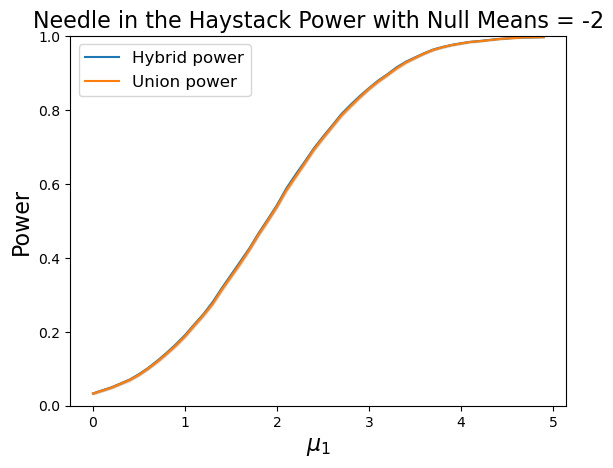

In [434]:
alpha = 0.05
beta = alpha/10
n = 10
mu1s = np.arange(0, 5, step=0.1)
mu2 = -2
sigma = np.ones(n)
sigma[0]=1
sigma[1:]=1

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = []
union_power = []
class_power = []

for i in range(len(mu1s)):
        mu1 = mu1s[i] 
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1:] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :]) 
        hybrid_power.append(np.mean(hybrid_reject(ps, alpha, beta)))
        union_power.append(np.mean(union_reject(ps, alpha, beta)))

hybrid_power = np.array(hybrid_power)
union_power = np.array(union_power)

hybrid_std_dev = np.sqrt(hybrid_power * (1 - hybrid_power) / N)
hybrid_upper_bound = hybrid_power + hybrid_std_dev
hybrid_lower_bound = hybrid_power - hybrid_std_dev
plt.plot(mu1s, hybrid_power, label='Hybrid power', color='tab:blue')
plt.fill_between(mu1s, hybrid_lower_bound, hybrid_upper_bound, color='tab:blue', alpha=0.3)    

union_std_dev = np.sqrt(union_power * (1 - union_power) / N)
union_upper_bound = union_power + union_std_dev
union_lower_bound = union_power - union_std_dev
plt.plot(mu1s, union_power, label='Union power', color='tab:orange')
plt.fill_between(mu1s, union_lower_bound, union_upper_bound, color='tab:orange', alpha=0.3)    

plt.xlabel("$\mu_1$", fontsize=16)
plt.ylabel("Power", fontsize=16)
plt.title(f"Needle in the Haystack Power with Null Means = {mu2}", fontsize=16)

plt.legend(fontsize=12)
plt.ylim([0, 1])

plt.savefig(f"fig/hybrid_vs_union_null={mu2}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [250]:
alpha = 0.05
beta = alpha/10
mus = np.arange(-3, 3.1, step=0.1)
sigma = np.ones(n)
sigma[0]=2
sigma[1]=1/2

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = {}
union_power = {}

for i in range(len(mus)):
    for j in range(i + 1):
        mu1, mu2 = mus[i], mus[j]
        if mu1 < 0.01:
            continue
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :])
        ps[:, 2:] = 1
        hybrid_power[(mu1, mu2)] = np.mean(hybrid_reject(ps, alpha, beta))
        union_power[(mu1, mu2)] = np.mean(union_reject(ps, alpha, beta))




0.02859999999999996
0.0025000000000000022
0.014600000000000035
1395


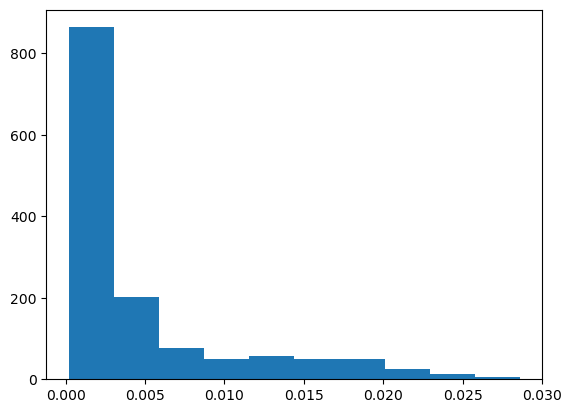

In [251]:
diffs = []
for key in union_power:
    diffs.append(hybrid_power[key] - union_power[key])
plt.hist(diffs)
print(np.max(diffs))
print(np.median(diffs))
print(np.quantile(diffs, 0.9))
print(len(diffs))

### Rank Verification and Randomization

In [23]:
# X ~ Bin(n, p1)
# Y ~ Bin(n, p2)


#test null that p1 <= p2
def binom_p_val(b, X, Y):

  num_tests = len(X)

  U = np.random.uniform(0, 1, size=num_tests)
  total=2*b
  successes=X+Y
  drawn=b

  p_val_lower = 1 - hypergeom.cdf(X, M=total, n=successes, N=drawn)
  p_val_upper = 1 - hypergeom.cdf(X - 1, M=total, n=successes, N=drawn)

  return p_val_lower + U*(p_val_upper - p_val_lower)

In [24]:
num_tests = int(1e7)
b = 4
p= 0.5
X = hypergeom.rvs(M=2*b, n=b, N=b, size=num_tests)
Y = b - X

In [25]:
n = 3
winners = np.where(X > int(b/2))[0]
winners_ = np.where(X == int(b/2) )[0]
mask = np.array(np.random.binomial(1, 1/n, size=len(winners_)), dtype=bool)
winners_ = winners_[mask]
all_winners = np.concatenate([winners, winners_])

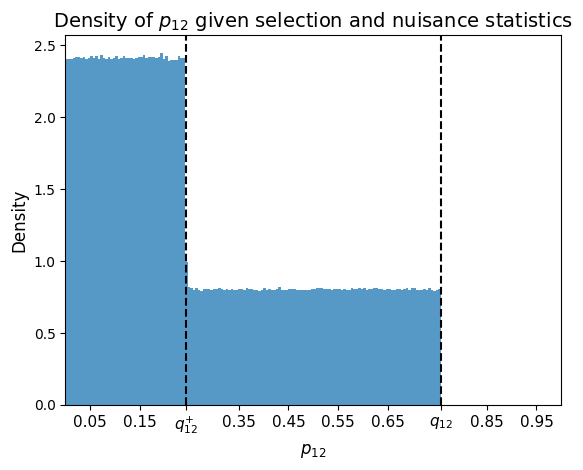

In [26]:
ps = binom_p_val(b, X[all_winners], Y[all_winners])
plt.hist(ps, bins=150, density=True, color='tab:blue', alpha=0.75)
q_plus = 1 - hypergeom.cdf(int(b/2), M=2*b, n=b , N=b)
q = 1 - hypergeom.cdf(int(b/2) - 1, M=2*b, n=b , N=b)
plt.title("Density of $p_{12}$ given selection and nuisance statistics", fontsize=14)
plt.ylabel("Density", fontsize=12)
plt.xlabel("$p_{12}$", fontsize=12)
plt.axvline(q, linestyle='--', color='black') 
plt.axvline(q_plus, linestyle='--', color='black') 


tick_positions = list(np.round(np.arange(0.05, 1.05, step=0.1), 2))
tick_positions.remove(0.25)
tick_positions.remove(0.75)
tick_labels = tick_positions.copy()

tick_positions += [q_plus, q]  
tick_labels += ['$q^{+}_{12}$', '$q_{12}$']  
plt.xticks(tick_positions, tick_labels, fontsize=11)

plt.xlim([0, 1])

plt.savefig(f"fig/p_val_density.pdf", bbox_inches='tight', pad_inches=0)

fig = plt.gcf()
figsize = fig.get_size_inches()


In [27]:
b=4
num_tests = int(1e5)
n=3
alpha = 0.1
B = np.random.binomial(b, 0.5, size=(num_tests, n))

num_winners = np.sum(B == np.max(B, axis=1).reshape(num_tests, 1), axis=1)
winners = np.argmax(B, axis = 1) 
selected = np.where(winners == 0)[0]
num_winners = num_winners[selected]
randomly_selected = np.random.binomial(1, 1/num_winners)
selected = selected[randomly_selected == 1]
num_winners = num_winners[randomly_selected == 1]
B = B[selected, :]


N = 1 + np.sum(B[: , 1:] == np.max(B[: , 1:], axis=1).reshape(len(B), 1), axis=1)
Y = B[:, 1]
X = B[:, 0]

ps = binom_p_val(b, X, Y)

cutoffs = (X + Y)/2
if n > 2:
    cutoffs = np.maximum(cutoffs, np.max(B[:, 2:], axis=1))

q_pluses = np.zeros(len(cutoffs))
qs = np.zeros(len(cutoffs))

not_integer = np.where(cutoffs != np.round(cutoffs))[0]
integer = np.where(cutoffs == np.round(cutoffs))[0]

q_pluses = 1 - hypergeom.cdf(cutoffs - 1, M=2*b, n=X+Y , N=b)

if len(not_integer) > 0:
    q_pluses[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)
    qs[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)

if len(integer) > 0:
    q_pluses[integer] = 1 - hypergeom.cdf(cutoffs[integer], M=2*b, n=(X+Y)[integer] , N=b)
    qs[integer] = 1 - hypergeom.cdf(cutoffs[integer] - 1, M=2*b, n=(X+Y)[integer], N=b)

fithian_ps = ps/qs 
my_ps = (ps - (1 - 1/N) * np.maximum(ps - q_pluses, 0))/(q_pluses + 1/N * (qs - q_pluses))



In [28]:
alpha = 0.1
fithian_error = np.mean(fithian_ps < alpha)
my_error = np.mean(my_ps < alpha)
fithian_se = np.sqrt((fithian_error * (1- fithian_error))/len(my_ps))
my_se = np.sqrt((my_error * (1- my_error))/(len(my_ps)))


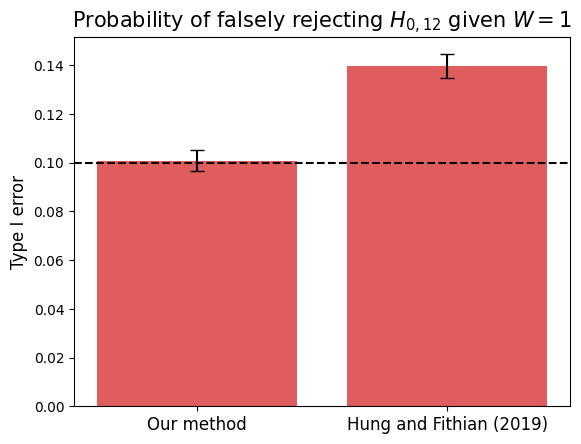

In [30]:

bar_heights = [my_error, fithian_error]
error_heights = [norm.ppf(1 - 0.01/2)*my_se, norm.ppf(1 - 0.01/2)*fithian_se]
bar_labels = ["Our method", "Hung and Fithian (2019)"]

x_positions = np.arange(len(bar_heights))

plt.figure(figsize=figsize) 
plt.bar(x_positions, bar_heights, yerr=error_heights, capsize=5, color='tab:red', alpha=0.75)
plt.xticks(x_positions, bar_labels, fontsize=12) 

plt.axhline(y=alpha, color='black', linestyle='--')

plt.ylabel("Type I error", fontsize=12)
plt.title("Probability of falsely rejecting $H_{0, 12}$ given $W=1$", fontsize=15)

plt.savefig(f"fig/type_one_error.pdf", bbox_inches='tight', pad_inches=0)

### Rank Verification Warm-up Plot

In [4]:
b = 1000
mu1s = np.linspace(-3, 3, b)
mu2 = 0
alpha=0.1

inequality_error = np.zeros(b)
equality_error = np.zeros(b)

for i, mu1 in enumerate(mu1s):
    inequality_error[i] = (1 - norm.cdf(norm.ppf(1-alpha) + (mu1 - mu2))) * (mu1 > mu2) + (1 - norm.cdf(norm.ppf(1-alpha) + (mu2 - mu1))) * (mu2 > mu1) 
    equality_error[i] = (1 - norm.cdf(norm.ppf(1-alpha) + (mu1 - mu2))) * (mu1 >= mu2) + (1 - norm.cdf(norm.ppf(1-alpha) + (mu2 - mu1))) * (mu2 >= mu1) 

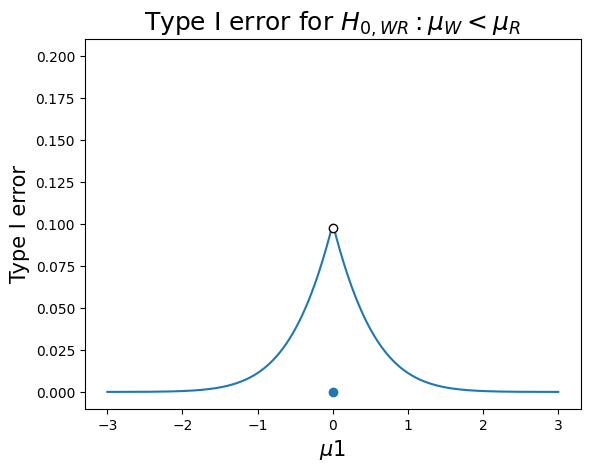

In [836]:

plt.plot(mu1s, inequality_error) 
plt.plot()
plt.xlabel("$\mu1$", fontsize=15)
plt.ylabel("Type I error", fontsize=15)
plt.plot(0, alpha-0.0025, 'o', color='white', markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.scatter(0, 0, )
plt.title("Type I error for $H_{0, WR} : \mu_W < \mu_R$", fontsize=18)
plt.ylim([-0.01, 0.21])
plt.savefig(f"fig/inequality_error.pdf")

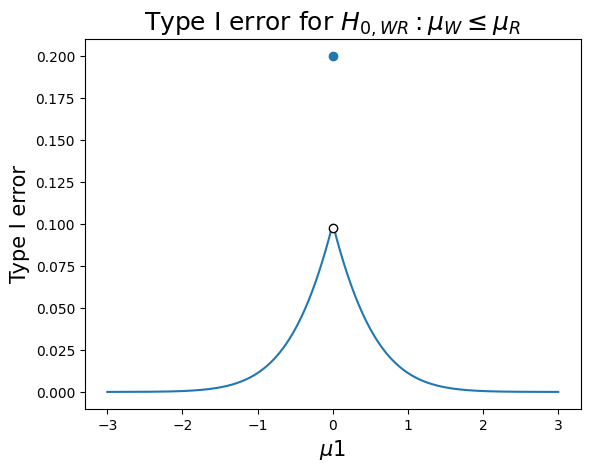

In [5]:

plt.plot(mu1s, equality_error) 
plt.plot()
plt.xlabel("$\mu1$", fontsize=15)
plt.ylabel("Type I error", fontsize=15)
plt.plot(0, alpha-0.0025, 'o', color='white', markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.scatter(0, 2*alpha)
plt.title("Type I error for $H_{0, WR} : \mu_W \leq \mu_R$", fontsize=18)
plt.ylim([-0.01, 0.21])
plt.savefig(f"fig/equality_error.pdf")

### Fisher's combination test

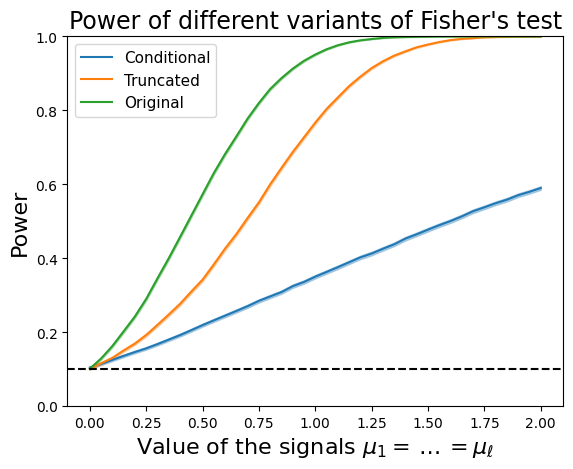

In [17]:
N = int(1e4)
n = 10 
ell = 10
alpha=0.1

mu_null = -2

tau = 0.5
k = 3
mus = np.arange(0, 2.05, step=0.05)

X = np.random.normal(0, 1, size=(N, n))

cond_power = np.zeros(len(mus))
trunc_power = np.zeros(len(mus))
orig_power = np.zeros(len(mus))

for i, mu in enumerate(mus):
    X_ = X.copy()
    X_[:, :ell] += mu
    X_[:, ell:] += mu_null 
    ps = 1 - norm.cdf(X_)
    ps = np.sort(ps, axis=1)

    orig_stats = -2*np.sum(np.log(ps), axis=1)
    orig_crit_val = chi2.ppf(1-alpha, df=2*n)
    orig_power[i] = np.mean(orig_stats > orig_crit_val)

    # conditional

    cond_stats = -2*np.sum(np.log(ps[:, :k]/ps[:, k].reshape(N, 1)), axis=1)
    cond_crit_val = chi2.ppf(1-alpha, df=2*k)
    cond_power[i] = np.mean(cond_stats > cond_crit_val)

    # trunc 

    below = ps < tau
    trunc_stats = -2*np.sum(np.log(ps/tau) * below, axis=1)
    num_selected = np.sum(below, axis = 1)
    trunc_crit_val = chi2.ppf(1-alpha, df=2*num_selected)
    trunc_power[i] = np.mean(trunc_stats > trunc_crit_val)



cond_std_dev = np.sqrt(cond_power * (1 - cond_power) / N)
cond_upper_bound = cond_power + cond_std_dev
cond_lower_bound = cond_power - cond_std_dev
plt.plot(mus, cond_power, label="Conditional", color='tab:blue')
plt.fill_between(mus, cond_lower_bound, cond_upper_bound, color='tab:blue', alpha=0.3)    

trunc_std_dev = np.sqrt(trunc_power * (1 - trunc_power) / N)
trunc_upper_bound = trunc_power + trunc_std_dev
trunc_lower_bound = trunc_power - trunc_std_dev
plt.plot(mus, trunc_power, label="Truncated", color='tab:orange')
plt.fill_between(mus, trunc_lower_bound, trunc_upper_bound, color='tab:orange', alpha=0.3)    

orig_std_dev = np.sqrt(orig_power * (1 - orig_power) / N)
orig_upper_bound = orig_power + orig_std_dev
orig_lower_bound = orig_power - orig_std_dev
plt.plot(mus, orig_power, label="Original", color='tab:green')
plt.fill_between(mus, orig_lower_bound, orig_upper_bound, color='tab:green', alpha=0.3)   

plt.xlabel("Value of the signals $\mu_1 = \dots = \mu_{\ell}$", fontsize=16)
plt.ylabel("Power", fontsize=16)
plt.title(f"Power of different variants of Fisher's test", fontsize=17)
plt.ylim([0,1])


plt.legend(fontsize=11)
plt.axhline(alpha, linestyle='--', color='black')

plt.savefig(f"fig/fisher_ell={ell}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

### Car Engine: Real Data Analysis

In [766]:
# Exponential winner example 

def compute_exp_p(X, lamb):
    return expon.cdf(X, scale=1/lamb) 


def hybrid_CI(X, compute_p, theta_0, alpha=0.05, beta=0.005, eps=1e-8, step=1):
    
    n = len(X)

    beta_n = 1 - (1-beta)**(1/n)

    def obj(theta):
        ps = compute_p(X, theta)
        ps = np.sort(ps)
        return ps[0] - (alpha- beta)/(1-beta) * ps[1] - (1-alpha)/(1-beta) * beta_n
        #
    
    log_lower_guess = np.log(theta_0)
    log_upper_guess = np.log(theta_0)

    lower_obj_val = obj(np.exp(log_lower_guess))

    while lower_obj_val > 0:
        log_lower_guess -= step
        lower_obj_val = obj(np.exp(log_lower_guess))
 
    upper_obj_val = obj(np.exp(log_upper_guess))
    while upper_obj_val < 0:
        
        log_upper_guess += step
        upper_obj_val = obj(np.exp(log_upper_guess))

    log_middle_guess = (log_lower_guess + log_upper_guess)/2

    while np.abs(np.exp(log_upper_guess) - np.exp(log_lower_guess)) > eps:
        obj_val = obj(np.exp(log_middle_guess))
        if obj_val < 0:
            log_lower_guess = log_middle_guess
            log_middle_guess = (log_lower_guess + log_upper_guess)/2
        if obj_val > 0:
            log_upper_guess = log_middle_guess
            log_middle_guess = (log_lower_guess + log_upper_guess)/2

    return np.exp(log_lower_guess)



In [416]:
alpha =0.1
beta=0.01
lamb = np.array([0.01, 100])

X = np.random.exponential(1/lamb)
print(X)

lambda_hat_winner = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0)
lambda_hat_hybrid = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0.01)
lambda_hat_simul = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0.1)

[5.32186362e+01 1.93451238e-02]


In [ ]:
engine_df = pd.read_csv('data/engine.csv')
population_X = largest_ttf_per_id = engine_df.groupby('id')['ttf'].max().tolist()
population_X = np.array(population_X)

n = 2
N = 1000
alpha = 0.1

conditional = np.zeros(N)
#hybrid = np.zeros(N)
simultaneous = np.zeros(N)


for i in tqdm(range(N)):
    X = np.random.choice(population_X, n, replace=False)
    conditional[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=0)
    #hybrid[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=alpha/10)
    simultaneous[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=alpha)


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_1041/4029692239.py:4: RuntimeWarning: overflow encountered in scalar divide
  return expon.cdf(X, scale=1/lamb)
100%|██████████| 1000/1000 [00:19<00:00, 52.36it/s]


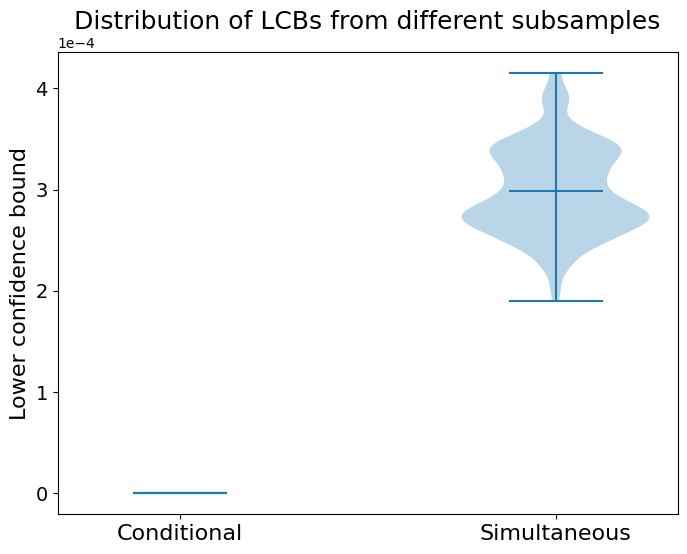

In [780]:
data = [conditional, simultaneous]
labels = ['Conditional', 'Simultaneous']

plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=True)

# Set labels for each plot
plt.xticks([1, 2], labels, fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Lower confidence bound', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
plt.title('Distribution of LCBs from different subsamples', fontsize=18)
plt.savefig(f"fig/car_eng.pdf")

### OSF Replication Analysis

47
92
39
34


/Users/anavsood/miniforge3/envs/seldom/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


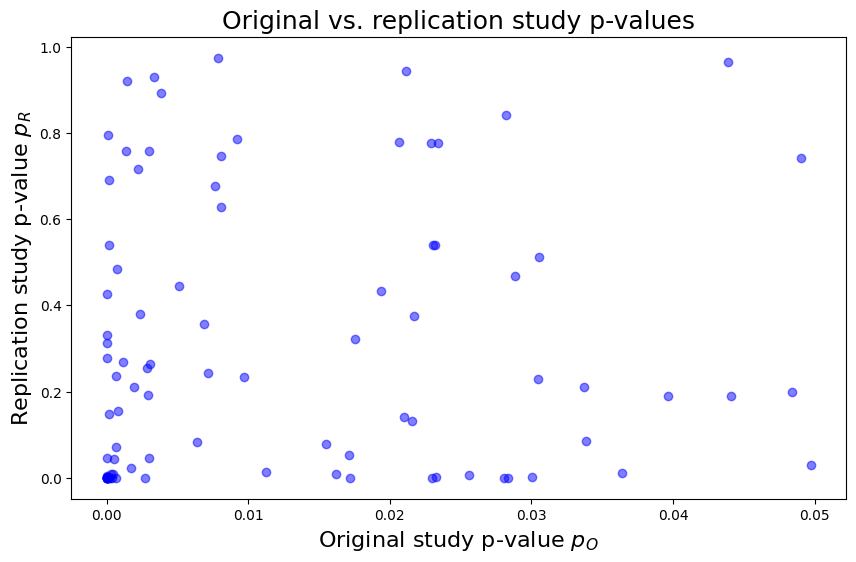

In [ ]:
alpha=0.05

rpp_df = pd.read_csv('data/rpp_data.csv', encoding='latin1')

rpp_df = rpp_df[['T_pval_USE..O.', 'T_pval_USE..R.']]

# Display the first few rows of the new DataFrame

filtered_rpp_df = rpp_df[
    (rpp_df['T_pval_USE..O.'] < alpha) &
    (rpp_df['T_pval_USE..O.'].notna()) &
    (rpp_df['T_pval_USE..R.'].notna())
]

stats = -2 * (np.log(filtered_rpp_df['T_pval_USE..O.'] / alpha) + np.log(filtered_rpp_df['T_pval_USE..R.']))
cutoff = chi2.ppf(1-alpha, df=4)

print(np.sum(stats > cutoff))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..O.'] < alpha)))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..O.'] < alpha**2)))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..R.'] < alpha)))

plt.figure(figsize=(10, 6))
plt.scatter(filtered_rpp_df['T_pval_USE..O.'], filtered_rpp_df['T_pval_USE..R.'], c='blue', alpha=0.5)


# Label the axes
plt.xlabel('Original study p-value $p_O$', fontsize=16)
plt.ylabel('Replication study p-value $p_R$', fontsize=16)

# Add a title and legend
plt.title('Original vs. replication study p-values', fontsize=18)
plt.savefig(f"fig/replication.pdf")

### Intro plots

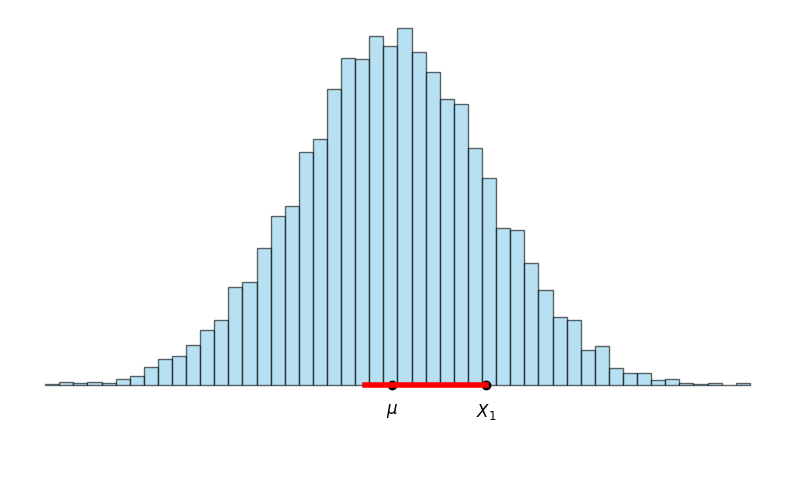

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0
std_dev = 1
num_samples = 10000

# Generate samples
samples = np.random.normal(mean, std_dev, num_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Remove axis labels, ticks, title, and frame
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Adjust y-limits to shift the plot up
y_min, y_max = plt.gca().get_ylim()
plt.gca().set_ylim(y_min -0.1, y_max )  # Shifting up by roughly 1 cm in figure units

# Mark points on the x-axis and highlight region
plt.plot(0, 0, 'ko')  # Dot at x = 0
plt.text(0, y_min - 0.02, r'$\mu$', ha='center', va='top', fontsize=12)

X1= 1
plt.plot(X1, 0, 'ko')  # Dot at x = 1
plt.text(X1, y_min - 0.02, r'$X_1$', ha='center', va='top', fontsize=12)

# Highlight the x-axis from 0 to 1 in a thicker red line
plt.plot([X1-norm.ppf(0.90), X1], [0, 0], color='red', linewidth=4)
# Show plot
plt.show()



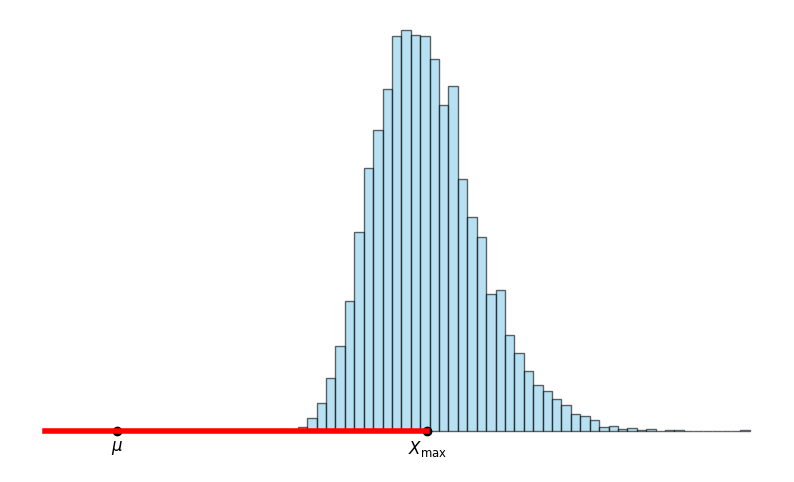

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0
std_dev = 1
num_samples = 10000

# Generate samples
n=100
samples = np.random.normal(mean, std_dev, (num_samples, n))
samples = np.max(samples, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Remove axis labels, ticks, title, and frame
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Adjust y-limits to shift the plot up
y_min, y_max = plt.gca().get_ylim()
plt.gca().set_ylim(y_min - 0.1, y_max )  # Shifting up by roughly 1 cm in figure units

# Mark points on the x-axis and highlight region
plt.plot(0, 0, 'ko')  # Dot at x = 0
plt.text(0, y_min - 0.02, r'$\mu$', ha='center', va='top', fontsize=12)

X1= 2.5
plt.plot(X1, 0, 'ko')  # Dot at x = 1
plt.text(X1, y_min - 0.02, r'$X_{\text{max}}$', ha='center', va='top', fontsize=12)

# Highlight the x-axis from 0 to 1 in a thicker red line
plt.plot([X1-norm.ppf((0.9)**(1/n)), X1], [0, 0], color='red', linewidth=4)
# Show plot
plt.show()


In [943]:
N =1000000
mu=-0.5

p = 1 - norm.cdf(np.random.normal(mu, 1, size=N))
U = np.random.uniform(0, 1, size=N)

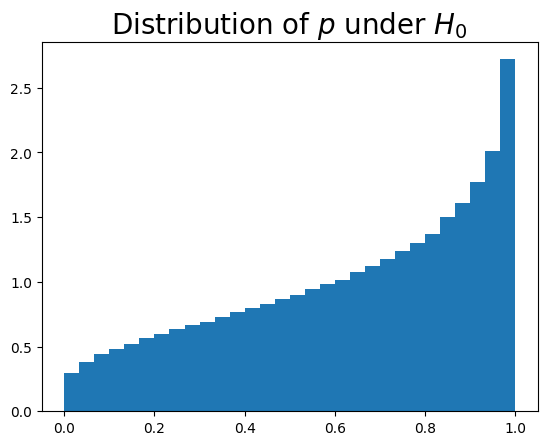

In [944]:
plt.hist(p, bins=30, density=True)
plt.title("Distribution of $p$ under $H_0$", fontsize=20)
#plt.axvline(0.5, color='tab:red')
plt.savefig(f"fig/p_dist.pdf")

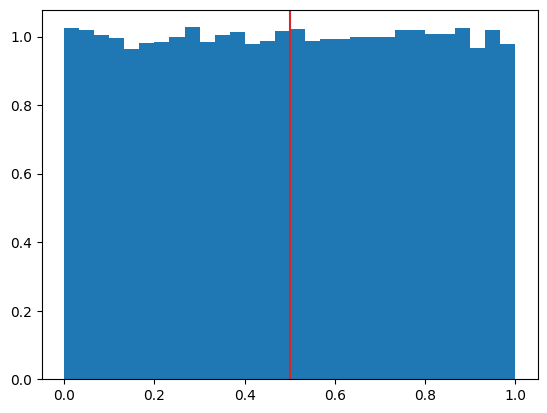

In [36]:
plt.hist(U, bins=30, density=True)
plt.axvline(0.5, color='tab:red')

In [945]:
N = 1000000

p = 1 - norm.cdf(truncnorm.rvs((norm.ppf(0.9) - mu) / 1, np.inf, loc=mu, scale=1, size=N))
U = np.random.uniform(0, 0.1, size=N)


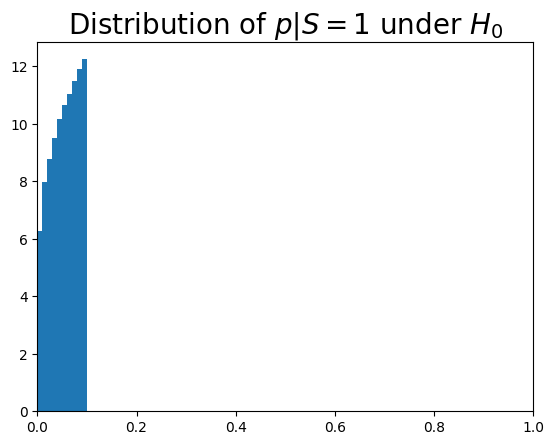

In [946]:
plt.hist(p, bins=10, density=True)
#plt.axvline(0.1, color='tab:red')
plt.title("Distribution of $p|S=1$ under $H_0$", fontsize=20)
plt.xlim([0, 1])
plt.savefig(f"fig/p_dist_given.pdf")

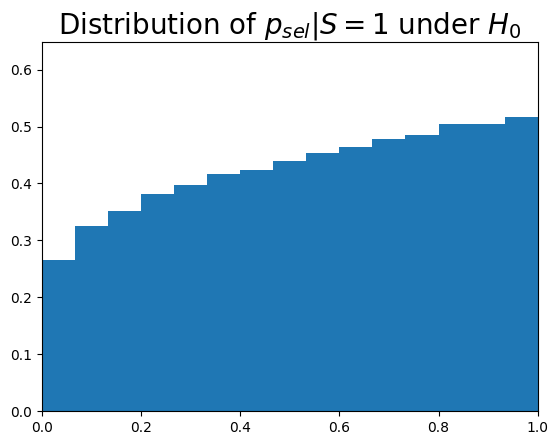

In [947]:
plt.hist(p/alpha, bins=30, density=True)
#plt.axvline(0.1, color='tab:red')
plt.title("Distribution of $p_{sel}|S=1$ under $H_0$", fontsize=20)
plt.xlim([0, 1])
plt.savefig(f"fig/p_sel_dist_given.pdf")

(0.0, 1.0)

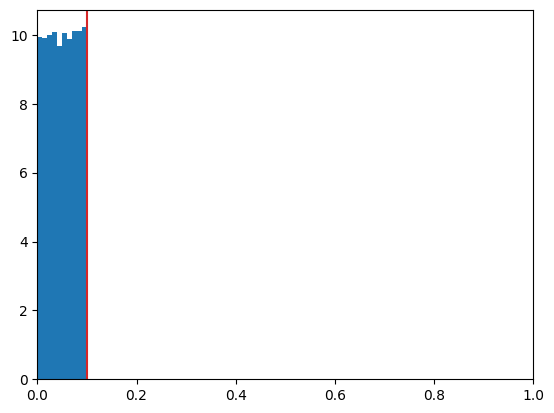

In [40]:
plt.hist(U, bins=10, density=True)
plt.axvline(0.1, color='tab:red')
plt.xlim([0, 1])